---
title: "Gumbel Softmax trick"
description: "A trick to enable gradient-based optimization over discrete choices."
date: 2025-07-04
categories: [deep learning, differentiable programming, reparameterization]
format: html
execute: 
  enabled: True
---

#### Can Neural Networks Learn to Make Hard Choices and Still Be Trained with Backprop?

Imagine your model needs to choose one among several categories say, Red, Green, or Blue.
The obvious choice? Use argmax or sample from a categorical distribution.
But here's the catch: backpropagation doesn't work through discrete decisions.

#### So, are we stuck?
**Not quite**. Say hello to the **Gumbel-Softmax** trick.<br>
You can’t backprop through discrete sampling directly but you can use a continuous relaxation like the Gumbel-Softmax, which approximates categorical sampling in a differentiable way.

#### Why argmax Kills Your Gradients

Backpropagation needs continuous functions. But argmax is not one it’s a discrete, non-differentiable operation.
That means if your model makes a hard choice using argmax, the gradient signal hits a wall.

Let’s see that in code:

```python
import torch
import torch.nn.functional as F

logits = torch.tensor([[2.0, 1.0, 0.1]], requires_grad=True)
probs = F.softmax(logits, dim=-1)
sample = torch.argmax(probs, dim=-1)

loss = sample.float().sum()
loss.backward()  #  Throws an error
```

The call to .backward() fails because gradients can’t flow through argmax it’s not differentiable with respect to logits.
The model can’t learn from this signal.

### The Magic Behind Gumbel-Softmax

What if, instead of making a hard discrete decision, your model makes a soft approximation one that’s almost one-hot but still differentiable?

That’s exactly what the Gumbel-Softmax trick does.
It turns the categorical sampling problem into a smooth, trainable operation.

Here’s the idea:

In [1]:
import torch
import torch.nn.functional as F

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax(logits, tau=1.0):
    g = sample_gumbel(logits.shape)
    return F.softmax((logits + g) / tau, dim=-1)


* logits are your raw scores (before softmax).

* g is Gumbel noise, which injects randomness to simulate sampling.

* tau is the temperature a hyperparameter that controls how sharp or soft the final distribution is.

* The final output is a differentiable approximation of a one-hot vector.

As `τ → 0`, the softmax output becomes almost one-hot, mimicking a discrete choice.
As `τ → ∞`, it becomes uniform, meaning the model explores all choices equally.

**Visual Example:** Learn to Blend Colors
Let’s bring this to life with a colorful example.

Imagine your model needs to select one color from a palette Red, Green, or Blue to match a target color like purple 💜.
But instead of choosing just one, it learns to blend them softly, using Gumbel-Softmax!

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

palette = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0]   # Blue
])

logits = torch.nn.Parameter(torch.randn(1, 3))

# Target color: Purple (blend of Red + Blue)
target = torch.tensor([[0.5, 0.0, 0.5]])

opt = torch.optim.Adam([logits], lr=0.1)

losses = []
for step in range(100):
    opt.zero_grad()
    probs = gumbel_softmax(logits, tau=0.5)  # Sample a soft blend
    color = probs @ palette                  # Weighted sum of RGB
    loss = F.mse_loss(color, target)
    losses.append(loss.item())
    loss.backward()
    opt.step()

    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss.item():.4f}")


Step 0: Loss = 0.0068
Step 10: Loss = 0.0021
Step 20: Loss = 0.1645
Step 30: Loss = 0.1280
Step 40: Loss = 0.0734
Step 50: Loss = 0.1265
Step 60: Loss = 0.1180
Step 70: Loss = 0.1632
Step 80: Loss = 0.0632
Step 90: Loss = 0.1468


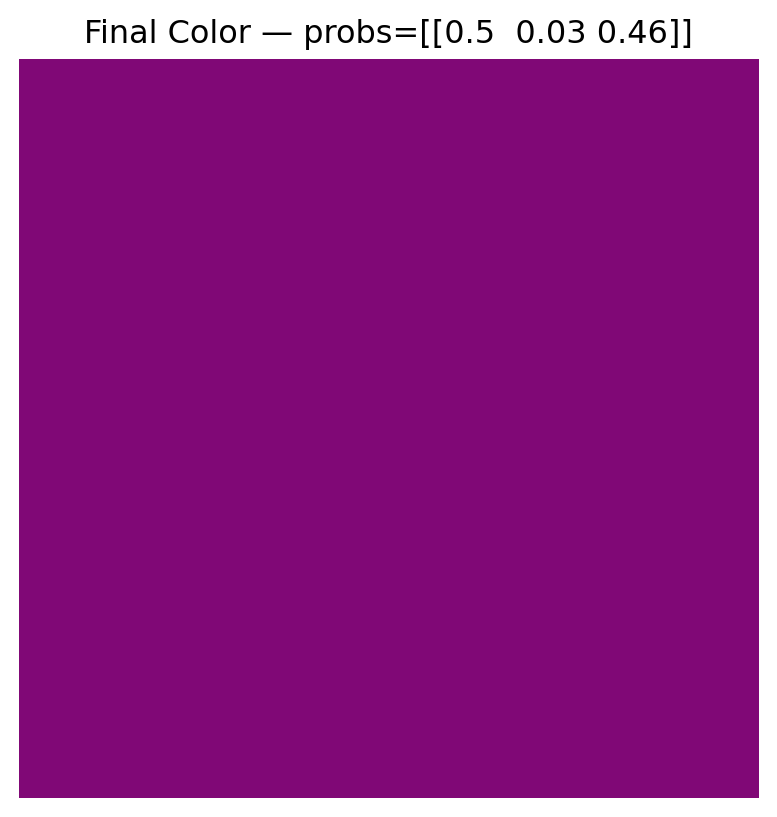

In [3]:
import matplotlib.pyplot as plt
with torch.no_grad():
    probs = F.softmax(logits, dim=-1)  # Final softmax
    blended = probs @ palette          # Final color

    plt.imshow(blended.view(1, 1, 3).numpy())
    plt.title(f"Final Color — probs={probs.numpy().round(2)}")
    plt.axis('off')
    plt.show()


#### *Even though we’re choosing among discrete options (RGB), Gumbel-Softmax lets the model learn differentiably by softly blending probabilities.*

Some reading material: [Arxiv Link](https://arxiv.org/pdf/1611.01144)